img shape =  (1024, 1024, 3)
output_img shape =  (1024, 1024, 3)


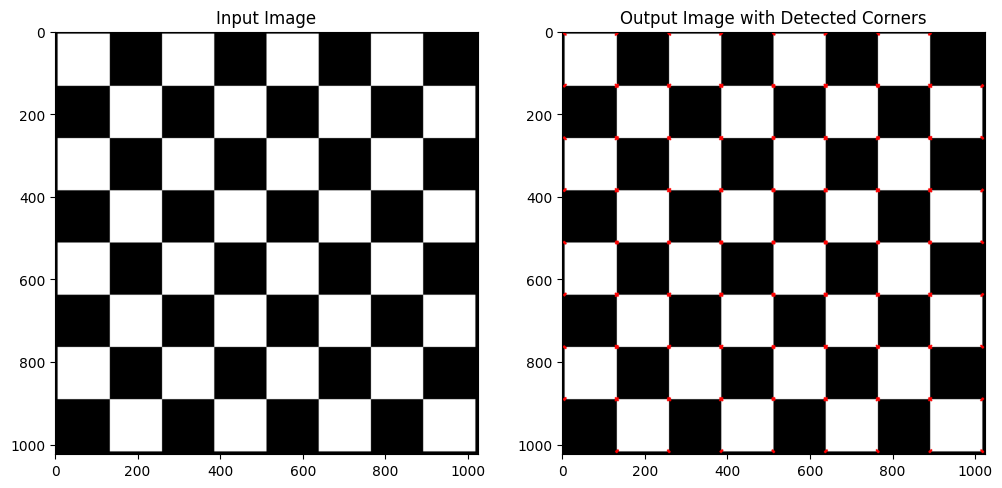

In [5]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to compute Harris Corners
def find_harris_corners(input_img, k=0.04, window_size=5, threshold=1000):
    """
    input_img: the image in which to find corners
    k: Harris detector free parameter
    window_size: size of the window considered for corner detection
    threshold: threshold for detecting corners
    """
    corners = []
    output_img = np.copy(input_img)
    if len(output_img.shape) == 3:
        processed_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2GRAY)
    else:
        processed_img = np.copy(output_img)
    print("output_img shape = ", output_img.shape)

    # Compute gradients using Sobel operator manually
    # Define Sobel kernels
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]], dtype=np.float32)

    # Convolve image with Sobel kernels
    Ix = convolve(processed_img, sobel_x)
    Iy = convolve(processed_img, sobel_y)

    # Compute products of derivatives
    Ixx = Ix ** 2
    Ixy = Ix * Iy
    Iyy = Iy ** 2

    # Apply Gaussian filter to the products
    Sxx = gaussian_filter(Ixx, window_size)
    Sxy = gaussian_filter(Ixy, window_size)
    Syy = gaussian_filter(Iyy, window_size)

    # Compute the response of the detector at each pixel
    R = (Sxx * Syy - Sxy ** 2) - k * ((Sxx + Syy) ** 2)

    # Threshold on R and find corners
    R_max = np.max(R)
    for y in range(R.shape[0]):
        for x in range(R.shape[1]):
            if R[y, x] > threshold:
                corners.append([x, y])
                # Mark the corner in the output image
                cv2.circle(output_img, (x, y), 2, (0, 0, 255), -1)

    return corners, output_img

# Updated Helper function: Convolution
def convolve(image, kernel):
    # Flip the kernel
    kernel = np.flipud(np.fliplr(kernel))
    output = np.zeros_like(image, dtype=np.float32)
    # Calculate padding widths
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    # Pad the image
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    # Convolve
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Element-wise multiplication and summation
            output[y, x] = (kernel * padded_image[y:y+kernel.shape[0], x:x+kernel.shape[1]]).sum()
    return output

# Helper function: Gaussian filter
def gaussian_filter(image, size, sigma=1):
    # Create a Gaussian kernel
    ax = np.linspace(-(size // 2), size // 2, size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    kernel = kernel / np.sum(kernel)
    # Convolve image with Gaussian kernel
    return convolve(image, kernel)

# Load and process the image
img = cv2.imread('/content/Chess_Board.png')
assert img is not None, "Image could not be read. Check the file path."
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("img shape = ", img.shape)

# Apply Harris Corner Detector
cornerList, outputImg = find_harris_corners(img, k=0.06, window_size=5, threshold=100000)
# threshold: empirically selected

# Display the results
f, axis_array = plt.subplots(1, 2, figsize=(12, 8))
axis_array[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axis_array[0].set_title('Input Image')
axis_array[1].imshow(cv2.cvtColor(outputImg, cv2.COLOR_BGR2RGB))
axis_array[1].set_title('Output Image with Detected Corners')
plt.show()


In [7]:
img = cv2.imread('/content/popularImage.png') # , cv2.IMREAD_GRAYSCALE, chess.png
assert img is not None, "file could not be read, check with os.path.exists()"
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[3:307, 3:307]
print(img_gray.shape)

(304, 304)


In [8]:
'''
Compute gradient of an image by rows and columns
'''
dx, dy = np.gradient(img_gray)
magnitude_gradient = np.sqrt(dy**2 + dx**2)
orientation_gradient = abs(np.rad2deg(np.arctan2(dy, dx))) # *180 / np.pi
# print(orientation_gradient)

In [9]:
bins = np.arange(0, 180, 20)
print(bins)

[  0  20  40  60  80 100 120 140 160]


In [10]:
def hog_cell(cell_mag, cell_dir, bins = [0, 20, 40, 60, 80, 100, 120, 140, 160]):
    '''
    magnitude of each orientation is distributed to bins using interpolation algorithm
    '''
    cell_hist = np.zeros(len(bins))
    last_bin_idx = len(bins) - 1
    mags = cell_mag.flatten()
    dirs = cell_dir.flatten()
    # print(dirs)
    # print(mags)
    for i in range(len(dirs)):
        for b in range(len(bins)):
            # print(b)
            if (dirs[i] > bins[b]) and b == len(bins)-1:
                cell_hist[b] += mags[i] - (dirs[i]-bins[last_bin_idx])/(180 - bins[last_bin_idx])*mags[i]
                cell_hist[0] += (dirs[i]-bins[last_bin_idx])/(180 - bins[last_bin_idx])*mags[i]
                # print("over 140", cell_hist)
            else:
                # print(Bins[b+1])
                if(dirs[i]>bins[b] and dirs[i]<=bins[b+1]):
                    cell_hist[b] += (bins[b+1]-dirs[i])/(bins[b+1] - bins[b])*mags[i]
                    cell_hist[b+1] += (dirs[i]-bins[b])/(bins[b+1] - bins[b])*mags[i]
    # print(cell_hist)
    return cell_hist

In [11]:
# for testing
cell_mag = np.array([[1, 2], [3, 4]])
cell_dir = np.array([[-125, 85], [150, 4]])
# print(cell)
cell_hist = hog_cell(cell_mag, cell_dir)
print(cell_hist, type(cell_hist))

[3.2 0.8 0.  0.  1.5 0.5 0.  1.5 1.5] <class 'numpy.ndarray'>


In [12]:
def hist_of_oriented_gradient(img_gray, window_size = 16, cell_size = 4):
    '''
    In this example, window size (patch size) and cell size are given as default
    If lecturer want to change these value, remember to resize image to suitable size
    '''
    dy, dx = np.gradient(img_gray)
    # print(dy.shape)
    magnitude_gradient = np.sqrt(dy**2 + dx**2)
    # print(magnitude_gradient.shape)
    orientation_gradient = abs(np.rad2deg(np.arctan2(dy, dx))) # *180 / np.pi
    yRange = img_gray.shape[0] // window_size
    xRange = img_gray.shape[1] // window_size
    # print("yRange, xRange = ", yRange, xRange)

    img_hist = np.array([])
    for y in range(yRange):
        for x in range(xRange):
            window = img_gray[(y*window_size):((y+1)*window_size), (x*window_size):((x+1)*window_size)]
            window_magnitude_gradient = magnitude_gradient[(y*window_size):((y+1)*window_size), (x*window_size):((x+1)*window_size)]
            window_orientation_gradient = orientation_gradient[(y*window_size):((y+1)*window_size), (x*window_size):((x+1)*window_size)]
            # if(y==yRange-1 and x==xRange-1): print(window_orientation_gradient.shape)
            window_hist = np.array([])
            iRange = int(np.sqrt(window_size/cell_size))
            for i in range(iRange):
                for j in range(iRange):
                    # if(y==0 and x==0): print("i, j = ", i, j)
                    cell_mag = window_magnitude_gradient[(i*cell_size):((i+1)*cell_size), (j*cell_size):((j+1)*cell_size)]
                    cell_dir = window_orientation_gradient[(i*cell_size):((i+1)*cell_size), (j*cell_size):((j+1)*cell_size)]
                    cell_hist = hog_cell(cell_mag, cell_dir)
                    # if(y==0 and x==0): print("cell_hist.shape = ", cell_hist.shape)
                    window_hist = np.hstack((window_hist, cell_hist))
            # print(window_hist)
            # if(y==0 and x==0): print("cell_hist shape, window_hist.shape = ", cell_hist.shape, window_hist.shape)
            img_hist = np.hstack((img_hist, window_hist))

    return img_hist.reshape(yRange*xRange, 36)

hog_fratures = hist_of_oriented_gradient(img_gray)
# print(hog_fratures)
print("hog_fratures = ", hog_fratures.shape)

hog_fratures =  (361, 36)


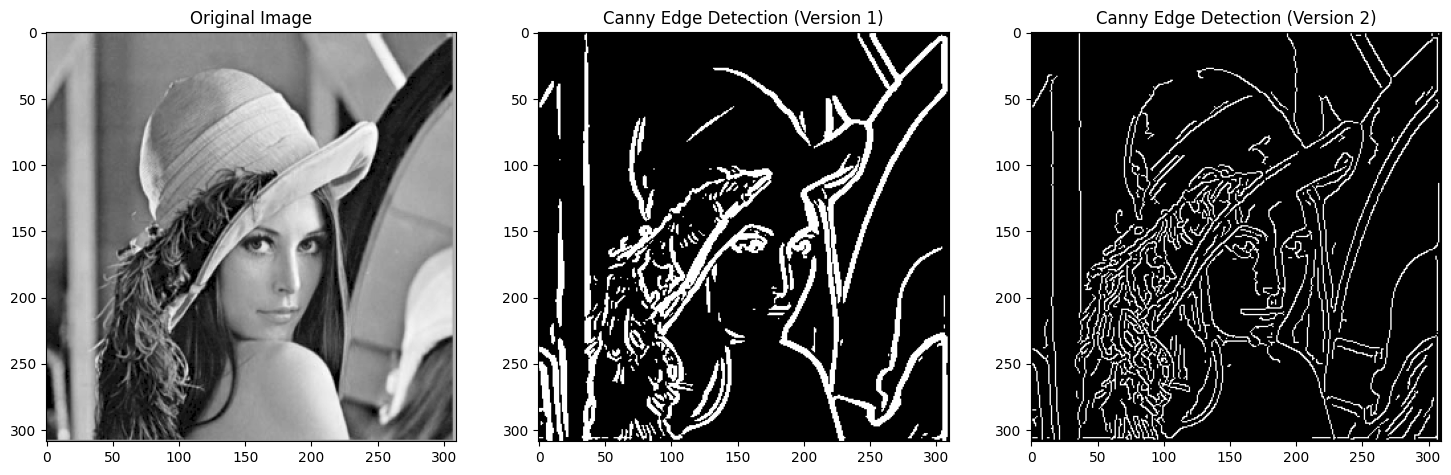

In [10]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Helper function: Convolution
def convolve(image, kernel):
    kernel = np.flipud(np.fliplr(kernel))
    output = np.zeros_like(image, dtype=np.float32)
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='reflect')
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            output[y, x] = (kernel * padded_image[y:y+kernel.shape[0], x:x+kernel.shape[1]]).sum()
    return output

# Function to create a Gaussian kernel
def gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

# Function for Edge Detection - Version 1 (Adjusted Implementation)
def edge_detection_v1(img, threshold_ratio=0.2):
    # Step 1: Smooth the image with Gaussian filter
    gaussian = gaussian_kernel(5, sigma=1.4)
    smoothed = convolve(img, gaussian)

    # Step 2: Compute gradients using Sobel operators (more precise)
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32) / 8
    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]], dtype=np.float32) / 8
    Ix = convolve(smoothed, Kx)
    Iy = convolve(smoothed, Ky)
    magnitude = np.hypot(Ix, Iy)

    # Normalize the magnitude
    magnitude = magnitude / magnitude.max() * 255

    # Step 3: Threshold the magnitude
    threshold = threshold_ratio * 255
    edges = (magnitude >= threshold).astype(np.uint8) * 255
    return edges

# Function for Canny Edge Detection - Version 2 (Adjusted Implementation)
def Canny_detector(img, lowThresholdRatio=0.05, highThresholdRatio=0.15):
    # Step 1: Noise reduction with Gaussian filter
    gaussian = gaussian_kernel(5, sigma=1.4)
    smoothed = convolve(img, gaussian)

    # Step 2: Compute gradients using Sobel operators
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32) / 8
    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]], dtype=np.float32) / 8
    Ix = convolve(smoothed, Kx)
    Iy = convolve(smoothed, Ky)
    magnitude = np.hypot(Ix, Iy)
    angle = np.arctan2(Iy, Ix)

    # Normalize the magnitude
    magnitude = magnitude / magnitude.max() * 255

    # Step 3: Non-maximum suppression (Adjusted for better edge thinning)
    nonMaxImg = non_max_suppression(magnitude, angle)

    # Step 4: Double thresholding (Adjusted thresholds)
    thresholdImg = threshold(nonMaxImg, lowThresholdRatio, highThresholdRatio)

    # Step 5: Edge tracking by hysteresis
    img_final = hysteresis(thresholdImg)

    return img_final

# Function to perform non-maximum suppression
def non_max_suppression(magnitude, angle):
    Z = np.zeros_like(magnitude, dtype=np.uint8)
    angle = angle * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1, magnitude.shape[0]-1):
        for j in range(1, magnitude.shape[1]-1):
            try:
                q = 255
                r = 255

                # Angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                # Angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                # Angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                # Angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]

                if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                    Z[i,j] = magnitude[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                pass
    return Z

# Function to perform double thresholding
def threshold(image, lowThresholdRatio=0.05, highThresholdRatio=0.15):
    highThreshold = image.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio

    res = np.zeros_like(image, dtype=np.uint8)
    strong_i, strong_j = np.where(image >= highThreshold)
    weak_i, weak_j = np.where((image <= highThreshold) & (image >= lowThreshold))

    res[strong_i, strong_j] = 255
    res[weak_i, weak_j] = 75  # Use 75 to differentiate weak edges

    return res

# Edge tracking by hysteresis
def hysteresis(image):
    M, N = image.shape
    res = image.copy()
    for i in range(1, M-1):
        for j in range(1, N-1):
            if res[i,j] == 75:
                if 255 in [res[i+1, j-1], res[i+1, j], res[i+1, j+1],
                           res[i, j-1], res[i, j+1],
                           res[i-1, j-1], res[i-1, j], res[i-1, j+1]]:
                    res[i,j] = 255
                else:
                    res[i,j] = 0
    res[res == 75] = 0  # Suppress any remaining weak edges
    return res

# Load and process the image
img = cv2.imread('/content/popularImage.png', cv2.IMREAD_GRAYSCALE)
assert img is not None, "Image could not be read. Check the file path."
img_gray = img.copy()

# Apply Edge Detection Version 1 (Adjusted Implementation)
edges_v1 = edge_detection_v1(img_gray, threshold_ratio=0.2)

# Apply Edge Detection Version 2 (Adjusted Canny Implementation)
edges_v2 = Canny_detector(img_gray, lowThresholdRatio=0.05, highThresholdRatio=0.1)

# Display the results
f, axis_array = plt.subplots(1, 3, figsize=(18, 6))
axis_array[0].imshow(img_gray, cmap='gray')
axis_array[0].set_title('Original Image')
axis_array[1].imshow(edges_v1, cmap='gray')
axis_array[1].set_title('Canny Edge Detection (Version 1)')
axis_array[2].imshow(edges_v2, cmap='gray')
axis_array[2].set_title('Canny Edge Detection (Version 2)')
plt.show()

In [12]:
def houghLine(image):
    # Get image dimensions
    # y for rows and x for columns
    Ny = image.shape[0]
    Nx = image.shape[1]

    # Max distance is diagonal one
    Maxdist = int(np.round(np.sqrt(Nx ** 2 + Ny ** 2)))

    # Theta in range from -90 to 90 degrees
    thetas = np.deg2rad(np.arange(-90, 90))
    # Range of radius
    rs = np.linspace(-Maxdist, Maxdist, 2 * Maxdist)
    accumulator = np.zeros((2 * Maxdist, len(thetas)))

    for y in range(Ny):
        for x in range(Nx):
            # Check if it is an edge pixel
            # NB: y -> rows , x -> columns
            if image[y, x] != 0:
                # Map edge pixel to hough space
                for k in range(len(thetas)):
                    # Calculate space parameter
                    r = x * np.cos(thetas[k]) + y * np.sin(thetas[k])
                    # Update the accumulator
                    # N.B: r has value -max to max
                    # map r to its idx 0 : 2*max
                    accumulator[int(r) + Maxdist, k] += 1
    return accumulator, thetas, rs

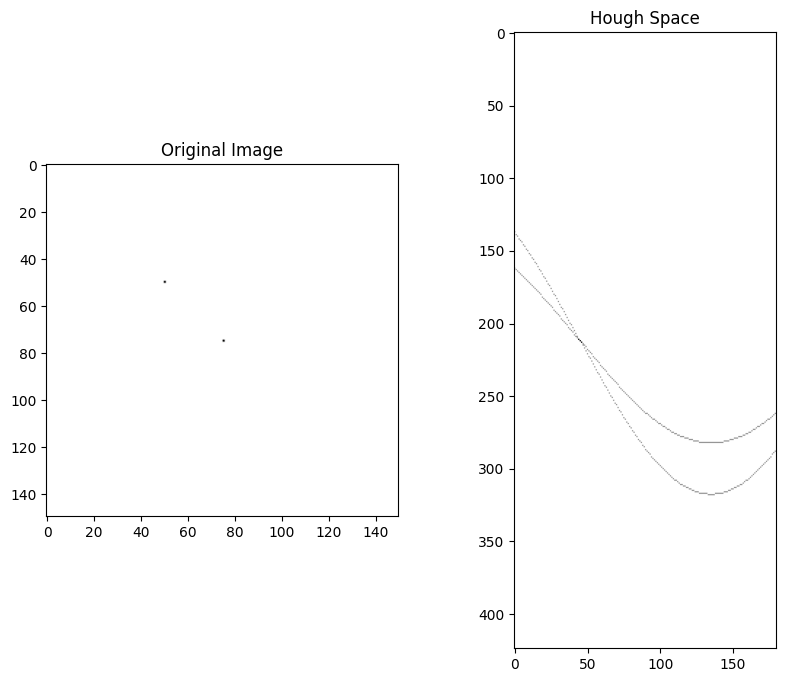

In [13]:
image = np.zeros((150,150))
image[75, 75] = 1
image[50, 50] = 1

accumulator, thetas, rhos = houghLine(image)
f, axarr = plt.subplots(1, 2, figsize = (10, 8))
axarr[0].title.set_text('Original Image')
axarr[0].imshow(image, cmap = 'Greys')
axarr[1].title.set_text('Hough Space')
axarr[1].imshow(accumulator, cmap = 'Greys')
# plt.set_cmap('gray')
plt.show()